# Chapter 6

## 6.1 Multicollinearity
## 6.2 Post-treatment Bias
## 6.3 Collider Bias
## 6.4 Confronting Confounding

## Intro
+ BERKSON'S PARADOX / SELECTION-DISTORTION EFFECT
+ Example below. Study proposals go to a committee, who rank on newsworthiness and trustworthiness. Each study gets an equally weighted rating assigned to newsw. and trustw., and tallies up the scores. Studies with highest scores are selected to go forward
+ Later someone does an analysis of studies and finds that newsworthiness and trustworthiness are negatively correlated
+ In the initial proposals, there was no correlation, but after selection there was.
+ This can happen with a multiple linear regression if we just keep adding variables. It iduces statistical selection inside the model - COLLIDER BIAS
![alt text](images/6/newsworthiness-trustworthiness.png "Title")

+ lecture 5 Link
    + https://www.youtube.com/watch?v=UpP-_mBvECI
    + Collider section at 40:34


In [1]:
suppressMessages({
library(rethinking)
library(dagitty)
    })

# 6.1 Multicollinearity
+ Why not add all varaibles to multiple linear regression? Because Multicollinearity
+ Multicollinearity means strong association between variables. 
+ Important problem is association conditional on other variables in the model.
+ Posterior distribution will suggest none of variables are reliably associated with the outcome, even if all are associated with the outcome.
+ BUT, the model will work fine for prediction!!!
+ You will not be able to understand the model

## 6.1.1 Multicollinear legs
+ Predict height from leg length. Use left and right leg length - (very slightly different)

In [2]:
set.seed(909)
N <- 100 # N people
height <-rnorm(N, 10, 2) # Simulate height of N people, mean 10, stdev 2
leg_prop <- runif(N, 0.4, 0.5) # Simulate leg length as 0.4 to 0.5 proportion of height
left_leg <- (leg_prop * height) + rnorm(N, 0, 0.02) # sim l leg with error
right_leg <- (leg_prop * height) + rnorm(N, 0, 0.02) # sim l leg with error
d <- data.frame(height, left_leg, right_leg)
str(d)

'data.frame':	100 obs. of  3 variables:
 $ height   : num  5.93 6.51 9.35 9.23 10.36 ...
 $ left_leg : num  2.68 2.68 3.93 3.96 4.43 ...
 $ right_leg: num  2.71 2.68 3.98 3.99 4.42 ...


In [3]:
m6.1 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + bl*left_leg + br*right_leg,
        a ~ dnorm(0, 100),
        bl ~ dnorm(2, 10),
        br ~ dnorm(2, 10),
        sigma ~ dexp(1)
    ), data=d)
precis(m6.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9811156,0.2839607,0.5272915,1.4349396
bl,0.2138054,2.5270797,-3.8249560,4.2525669
br,1.7817631,2.5312933,-2.2637325,5.8272587
sigma,0.6171141,0.0434363,0.5476945,0.6865337


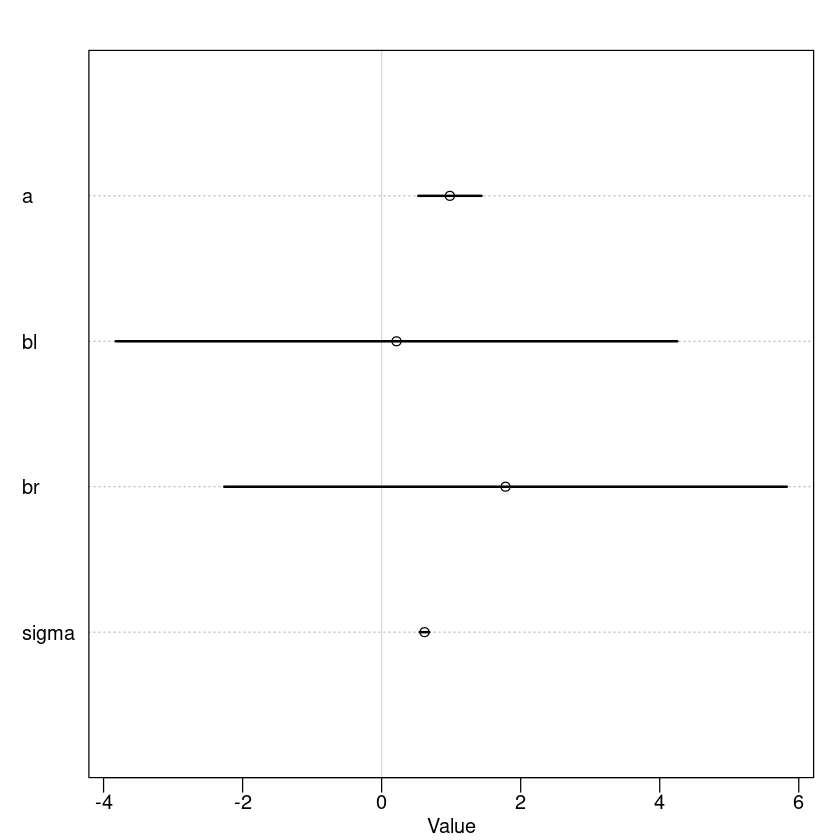

In [4]:
plot(precis(m6.1))

+ `Those posterior means and standard deviations look crazy` - I need a bit more help than that!
+ I guess the standard deviations for bl and br are higher than the mean. Not sure what else to look for here?
+ `What is the value of knowing each predictor, after already knowing all of the other predictors?` - so what is the value of knowing say the right leg length after knowing the right leg length
+ Plot the posterior distributions of bl and br against each other. These are very very strongly correlated. When bl is small, br must be big. 

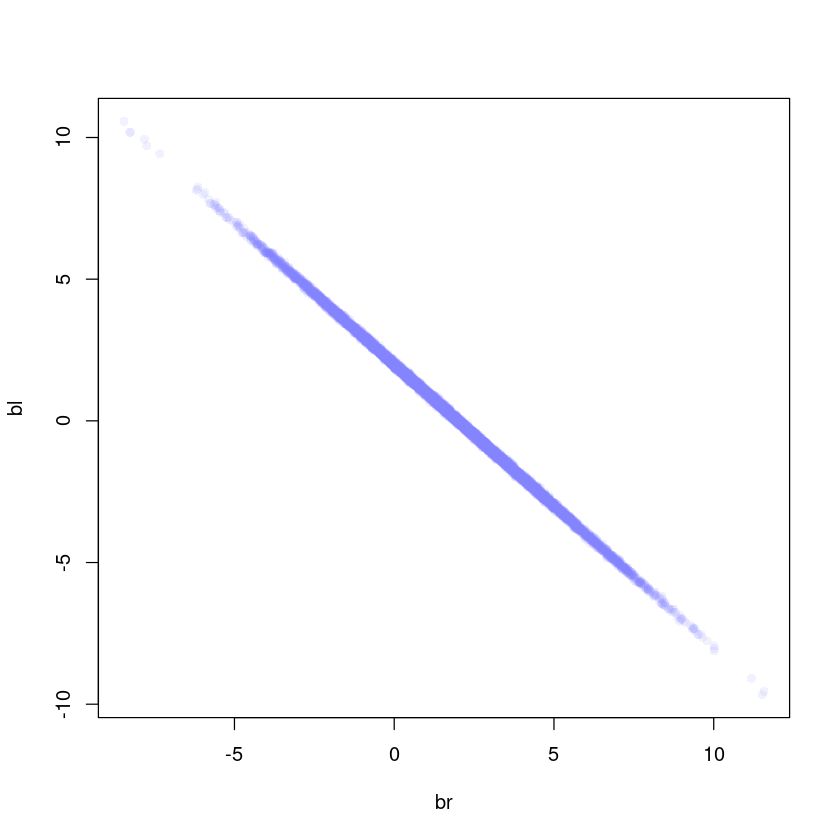

In [5]:
post <- extract.samples(m6.1)
plot( bl ~ br , post , col=col.alpha(rangi2,0.1) , pch=16 )

+ The model is like this:
    + $y_i \sim Normal(\mu_i, \sigma)$
    + $\mu_i = \alpha + \beta_1x_i + \beta_2x_i$
    + where:
        + x is a single predictor
+ But that is the like this:    
    + $\mu_i = \alpha + (\beta_1 + \beta_2)x_i$
+ The posterior is giving us back the sum of $\beta_1$ and $\beta_2$

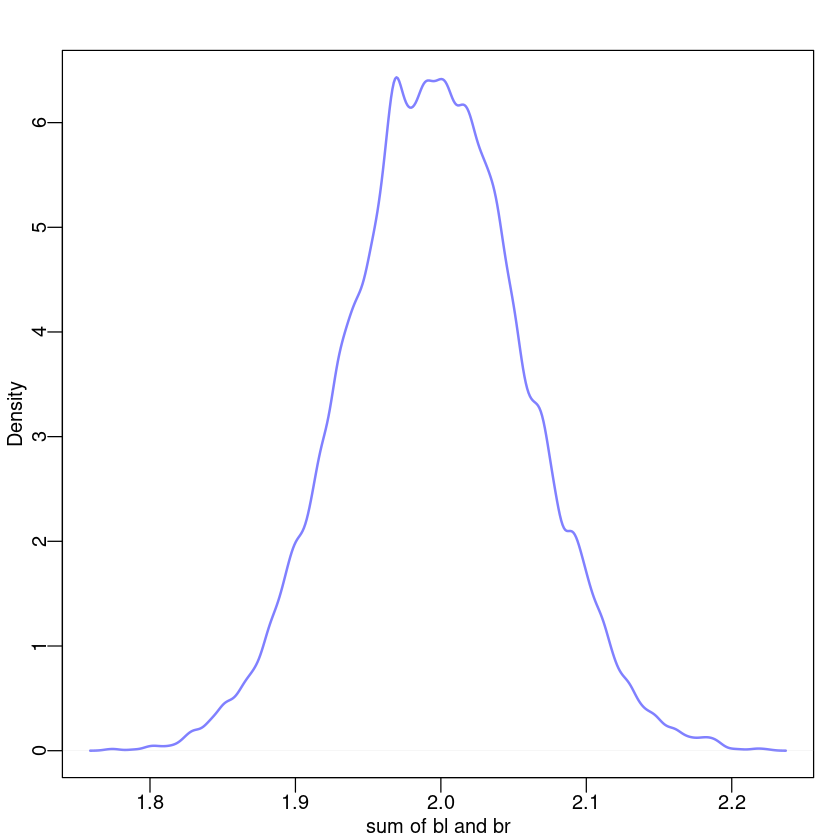

In [6]:
sum_blbr <- post$bl + post$br
dens(sum_blbr, col=rangi2, lwd=2, xlab="sum of bl and br")

+ Now fit regression using a single leg length

In [7]:
m6.2 <- quap(
 alist(
  height ~ dnorm(mu, sigma),
  mu <- a + bl*left_leg,
  a ~ dnorm(10, 100),
  bl ~ dnorm(2, 10),
  sigma ~ dexp(1)
 ) , data=d)

precis(m6.2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9979326,0.28364620,0.5446112,1.451254
bl,1.9920676,0.06115704,1.8943269,2.089808
sigma,0.6186038,0.04353998,0.5490185,0.688189


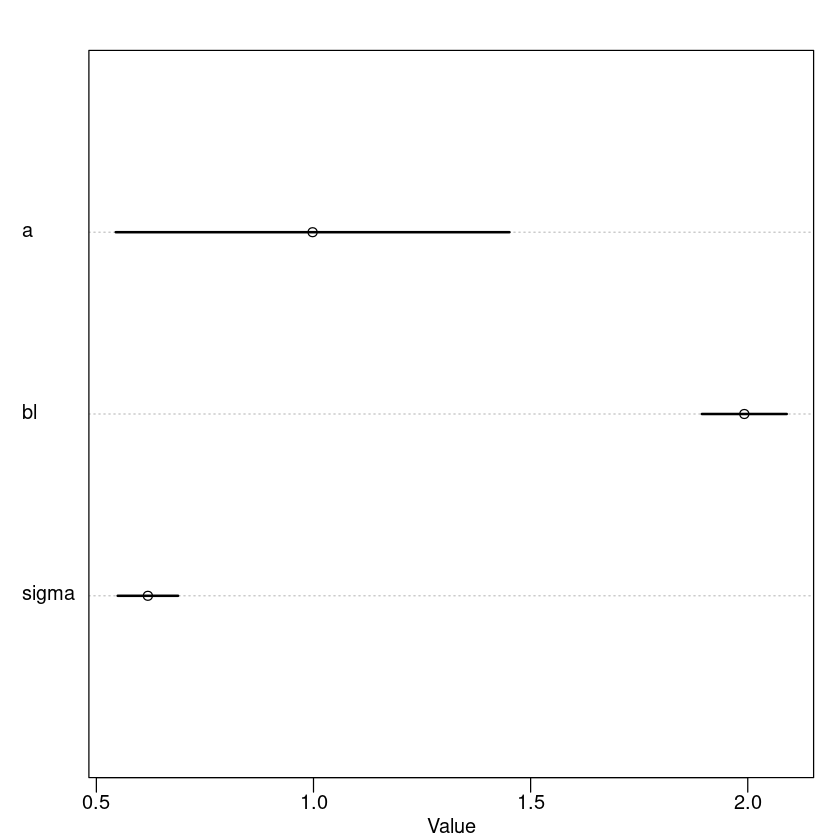

In [8]:
plot(precis(m6.2))

+ takeaway
+ When 2 predictors are highly correlated (conditional on other variables in the model) - What does this mean? - including both will be confusing.
+ Strictly the model output will be correct, but interpretability will be lacking
+ The risk is that we include highly correlated variables in the model, and the model tells us neither is important.

### 6.1.2 Multicollinear milk
+ Predict calories in milk from percentage lactose, and % fat

In [9]:
library(rethinking)
data(milk)
d <- milk
d$K <- standardize(d$kcal.per.g)
d$F <- standardize(d$perc.fat)
d$L <- standardize(d$perc.lactose)

[1] "K is target"


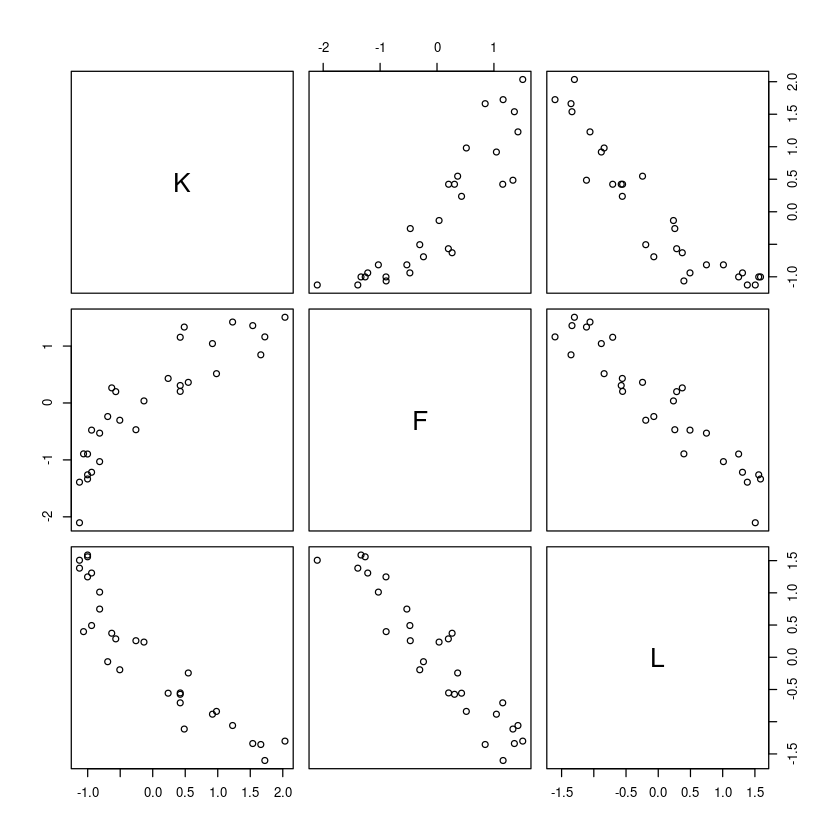

In [10]:
# pairs(d[, d$K, d$F, d$L])
pairs(d[, c("K", "F", "L")])
print('K is target')

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.535526e-07,0.07725195,-0.1234634,0.1234637
bF,8.618970e-01,0.08426088,0.7272318,0.9965621
sigma,4.510179e-01,0.05870756,0.3571919,0.5448440


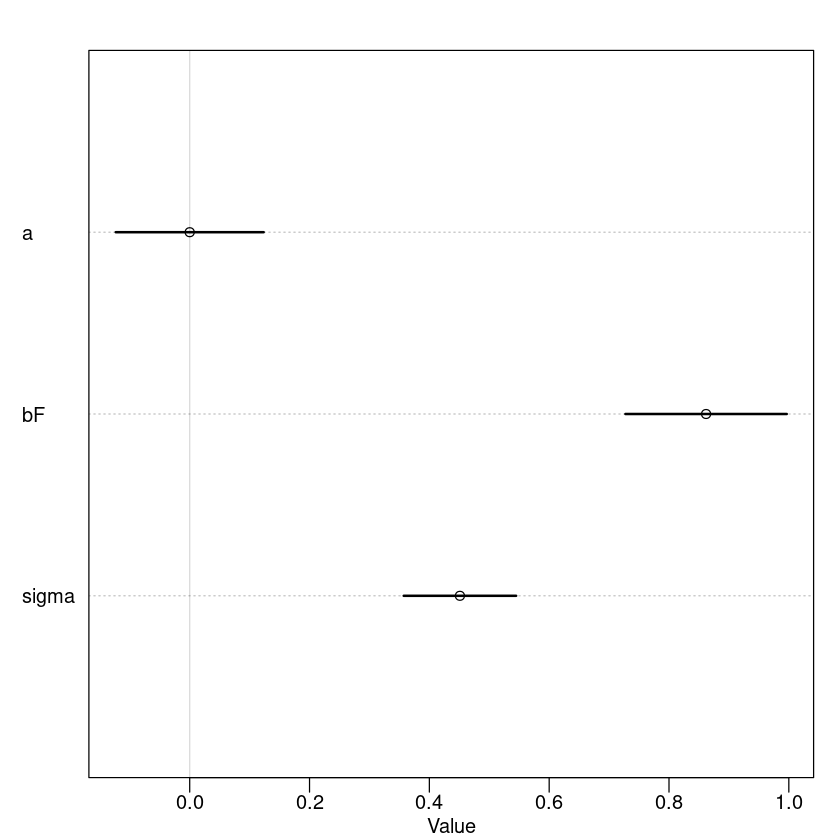

In [11]:
# kcal.per.g regressed on perc.fat
m6.3 <- quap(
 alist(
  K ~ dnorm(mu, sigma),
  mu <- a + bF*F,
  a ~ dnorm(0, 0.2),
  bF ~ dnorm(0, 0.5),
  sigma ~ dexp(1)
 ) , data=d )
precis(m6.3)
plot(precis(m6.3))

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,7.438895e-07,0.06661633,-0.1064650,0.1064665
bL,-9.024550e-01,0.07132848,-1.0164517,-0.7884583
sigma,3.804653e-01,0.04958259,0.3012227,0.4597078


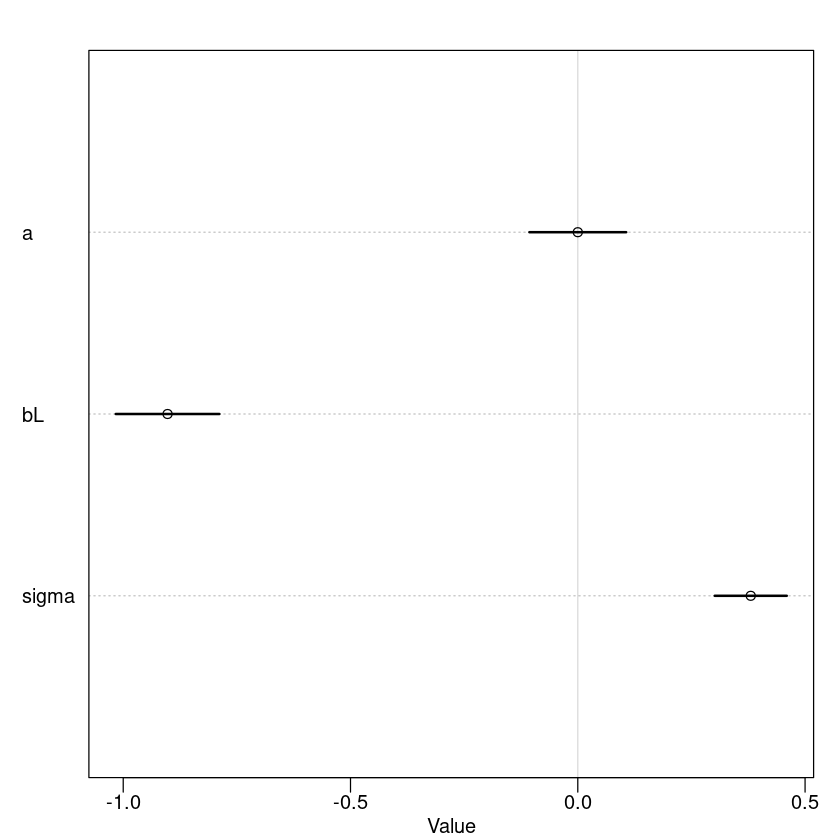

In [12]:
# kcal.per.g regressed on perc.lactose
m6.4 <- quap(
 alist(
  K ~ dnorm(mu, sigma),
  mu <- a + bL*L,
  a ~ dnorm(0, 0.2),
  bL ~ dnorm(0, 0.5),
  sigma ~ dexp(1)
 ) , data=d )
precis(m6.4)
plot(precis(m6.4))

+ Using both variables in the same model

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-3.172136e-07,0.06603577,-0.10553823,0.1055376
bF,2.434983e-01,0.18357865,-0.04989579,0.5368925
bL,-6.780825e-01,0.18377670,-0.97179320,-0.3843719
sigma,3.767418e-01,0.04918394,0.29813637,0.4553472


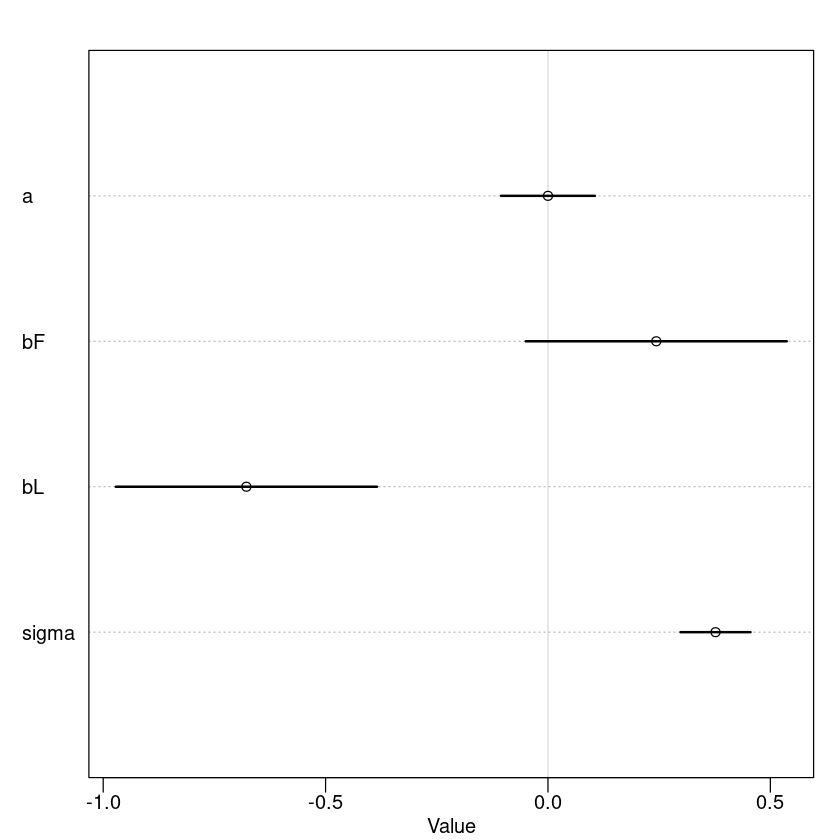

In [13]:
m6.5 <- quap(
 alist(
  K ~ dnorm(mu, sigma),
  mu <- a + bF*F + bL*L,
  a ~ dnorm(0, 0.2),
  bF ~ dnorm(0, 0.5),
  bL ~ dnorm(0, 0.5),
  sigma ~ dexp(1)
 ) , data=d)

precis(m6.5)
plot(precis(m6.5))

+ Easier to see on the plot than author's description
+ Standard deviations of $\beta$s are much bigger

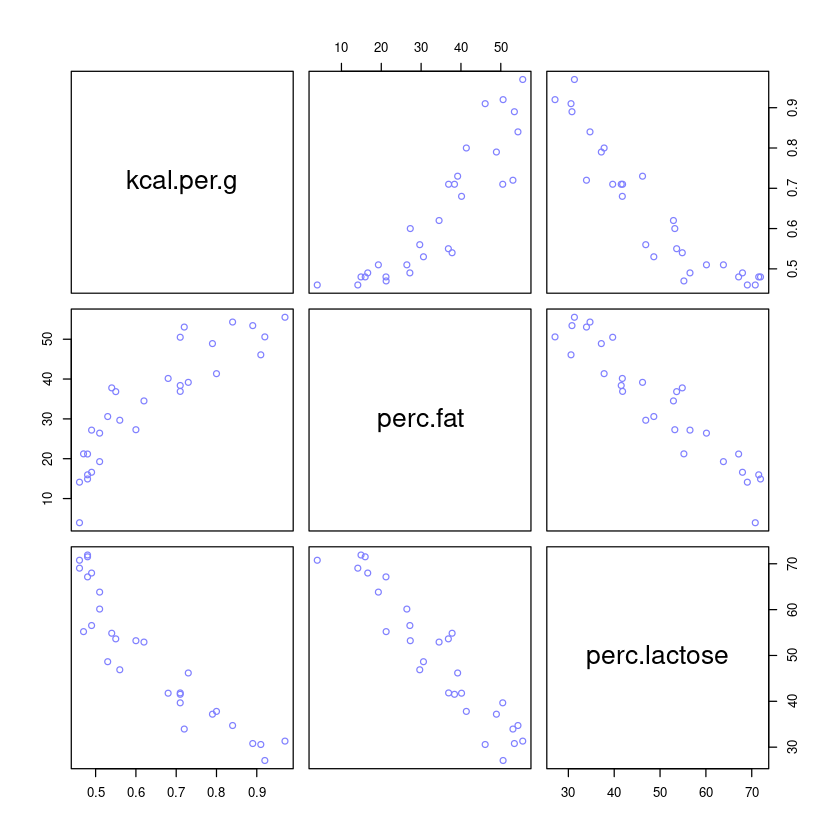

In [14]:
pairs( ~ kcal.per.g + perc.fat + perc.lactose , data=d , col=rangi2 )

+ takeaway
+ `Either helps in predicting kcal.per.g, but neither helps as much once you already know the other.`
+ WRONG APPROACH
    + inspect pairwise correlations prior to fitting a model and drop one side of highly correlated predictors
    + This is wrong because correlations do not matter - Conditional association matters
+ With the milk, there is likely a tradeoff between fat and lactose (lactose = sugar)
+ The causal model looks like:

![alt text](images/6/milk-causal-model.png "Title")

+ Tradeoff is D - Density - This is unobserved
+ If we could measure D, that would be a better causal model
+ NON-IDENTIFIABILITY - Parameter is not identified - the model structure means the variable's parameter cannot be estimated
+ If there is not much information in the data, then the posterior distribution will be similar to the prior. Can use this to gauge how much the model is helping us.
+ Simulation below (As per usual there is no title and the axes are labeled in the most minimal way possible)
+ Impreciseness of predictor (standard deviation) gets bigger as association between variables get bigger

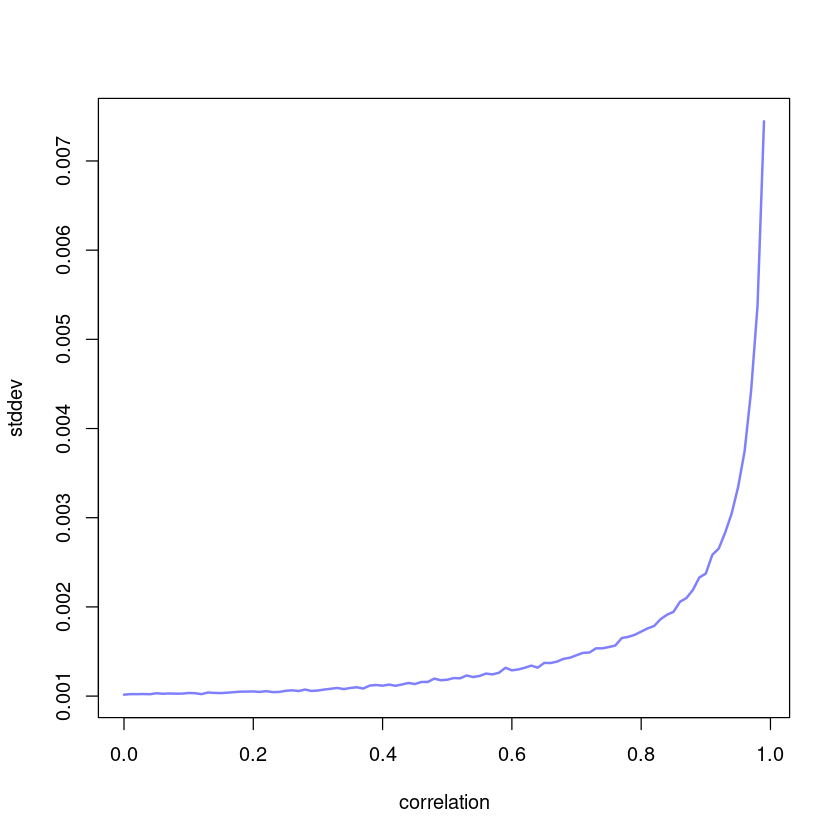

In [15]:
data(milk)
d <- milk
sim.coll <- function( r=0.9 ) {
 d$x <- rnorm( nrow(d) , mean=r*d$perc.fat ,
  sd=sqrt( (1-r^2)*var(d$perc.fat) ) )
 m <- lm( kcal.per.g ~ perc.fat + x , data=d )
 sqrt( diag( vcov(m) ) )[2] # stddev of parameter
}
rep.sim.coll <- function( r=0.9 , n=100 ) {
 stddev <- replicate( n , sim.coll(r) )
 mean(stddev)
}
r.seq <- seq(from=0,to=0.99,by=0.01)
stddev <- sapply( r.seq , function(z) rep.sim.coll(r=z,n=100) )
plot( stddev ~ r.seq , type="l" , col=rangi2, lwd=2 , xlab="correlation")

# 6.2 Post Treatment Bias

+ Missing variables that influence an outcome - OMITTED VARIABLE BIAS
+ The other way can also be a problem - INCLUDED VARIABLE BIAS Forms of this are:
    + POST-TREATMENT BIAS
+ Example problem setup:
    + Growing plants in greenhouse and conduct experiment on growth and fungus
    + Experiment purpose is to understand the difference in growth between plants under a set variety of anti-fungal treatments.
    + We know that more heavily fungused plants tend to grow less [I think the book says this]
    + Experiment process
        + Plants are seede and sprout [I guess this has to be simultaneous]
        + Heights are measured - $h_0$
        + Plants are [randomly] split into n groups
        + Different soil treatments are applied to each group
        + After set period of time, final measurements are taken:
            + final height $h_1$
            + presence of fungus - binary variable for each plant $fungus$
    + Summarizing the variables:
        + Total number of plants $N$ = 100 
        + Number of plants in each group is N/2 = 50
        + Initial plant height $h_0$ - continuous
        + Anti-fungal treatment applied $treatment$ - discrete, binary:- treatment applied/treatment not applied
        + Final height $h_1$ - continuous
        + Presence of fungus [at time of final height measurement] $fungus$ discrete, binary:- has fungus/does not have fungus
            

In [21]:
# R code 6.13
set.seed(71)
# number of plants
N <- 100
# Initial heights normally distributed withg mean 10, sd = 2
h0 <- rnorm(N, 10, 2)
# Assign treatments
treatment <- rep(0:1, each=N/2)
# Assign the fungus to the treatments
# probability of fungus = 0.5 - treatment * 0.4
# For non treated prob(fungus) = 0.5
# For treated prob(fungus) = 0.5-0.4 = 0.10
fungus <- rbinom(N, size=1, prob=0.5-treatment*0.4)
# docs: rnorm(n, mean = 0, sd = 1)
# Final height = initial height + random sample from normal distribution with sd=1 and [I think] mean at:
# non fungus plant change in height: 5-3*0 -> normally distributed mean=5, sd=1
# fungus plant change in height: 5-3*1 -> normally distributed mean=3, sd=1
h1 <- h0 + rnorm(N, 5-3*fungus)
# make df
d <- data.frame(h0=h0, h1=h1, treatment=treatment, fungus=fungus)
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
h0,9.95978,2.1011623,6.570328,13.07874,▁▂▂▂▇▃▂▃▁▁▁▁
h1,14.39920,2.6880870,10.618002,17.93369,▁▁▃▇▇▇▁▁
treatment,0.50000,0.5025189,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▇
fungus,0.23000,0.4229526,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▂


### Setting prior
+ We are fairly sure that final height >= initial height (should be)
+ If we consider the height data in terms of the **proportion** of initial height, this makes setting the priors easier.
+ For heights alone, linear model looks like:
    + $h_{1,i} \sim Normal(\mu_i, \sigma)$
    + $\mu_i = h_{0,i} \times p$
    + where:
        + $h_{0,i}$ - plant i's initial height
        + $h_{1,i}$ - plant i's final height
        + $p = \frac{h_{1,i}}{h_{0,i}}$
            + If p = 1, the plant has not grown
            + if p = 2, the height has doubled
        + We need a prior for p
            + if we center the prior on 1, then we are implying no height change
            + If we allow p to encompass values < 1, then we are considering the scenario where we stunt, or kill the plant
            + We have to ensure p > 0, because it is a proportion
            + All this means a good candidate for the prior is a log-normal distribution because it is always positive
            + Try $p \sim Log-Normal(0, 0.25)$    

In [23]:
sim_p <-rlnorm(10000, 0, 0.25)
precis(data.frame(sim_p))

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
sim_p,1.03699,0.2629894,0.670683,1.496397,▁▁▃▇▇▃▁▁▁▁▁▁


+ Interpreting this prior:
    + The author uses 5.5% to 94.5% interval to check the reasonableness of distributions
    + The 95% interval of p is from about 0.7, to 1.5 - so from 30% shorter to 50% bigger than the initial height
+ Code the partial model to see how it measures growth

In [24]:
# R Code 6.15
m6.6 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0*p,
        p ~ dlnorm(0, 0.25),
        sigma ~ dexp(1)
    ), data=d)
precis(m6.6)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
p,1.426626,0.01760992,1.398482,1.454770
sigma,1.793286,0.12517262,1.593236,1.993336


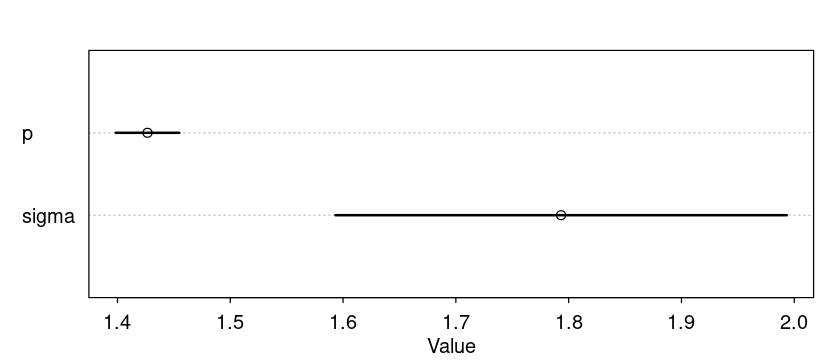

In [26]:
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.6))

+ This means the average proprtion change in height is about 1.4, so about 40% bigger than the initial plant
+ The 40% is across all treatments, and all fungus/no fungus plants
+ Modify the model to include treatment and fungus variables
+ The Treatment and the Fungus are now set up to impact **Change in proportion p**
    + The priors are setup the same as normalized/scaled/standardized [? - should find correct terminolgy for this] priors
    + Think about this trick to make prior estimation feasible? - Without this, I'm not sure where to even start on estimating priors 
    + This looks a bit like magic. need to think about this. can p go negative with this scheme?
+ Model looks like:
    + $h_{1,i} \sim Normal(\mu_i, \sigma$
    + $\mu_i = h_{0,i} \times p$
    + $p = \alpha + \beta_TT_i + \beta_FF_i$
    + $\alpha \sim LogNormal(0, 0.25)$
    + $\beta_T \sim Normal(0, 0.5)$
    + $\beta_F \sim Normal(0, 0.5)$
    + $\sigma \sim Exponential(1)$

In [27]:
# R code 6.16
m6.7 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p <- a + bt*treatment + bf*fungus,
        a ~ dlnorm(0, 0.2),
        bt ~ dnorm(0, 0.5),
        bf ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d)
precis(m6.7)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.481391468,0.02451069,1.44221865,1.52056429
bt,0.002412222,0.02986965,-0.04532525,0.05014969
bf,-0.266718915,0.03654772,-0.32512923,-0.20830860
sigma,1.408797442,0.09862070,1.25118251,1.56641237


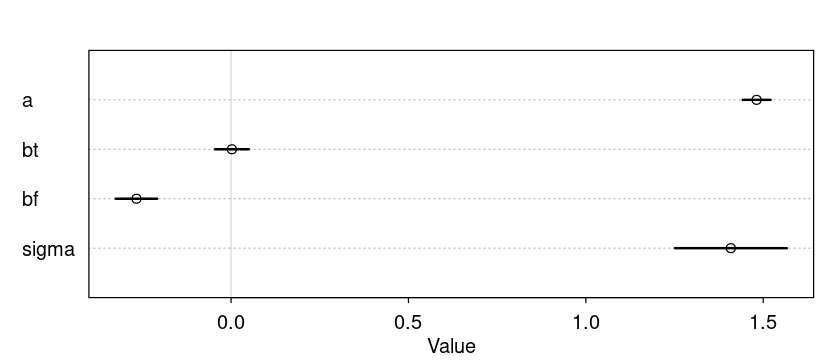

In [28]:
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.7))

+ The alpha parameter is about the same as we got for p
+ This says that treatment has no impact on growth. It is 0 or very small, so it has negligible impact in the linear equation
+ The fungus has a negative coefficint, so it hurts growth
+ Is this model correct?
+ We know fungus is mostly a consequnce of treatment
+ We call this  post-treatment variable - it's presence is a consequence of the treatment
+ This means the model is answering:
    + **Once we know whether a plant developed fungus, does ttreatment matter?**
+ The answer to this question is NO, because the treatment works by reducing fungus, hence allowing more growth
+ Actually our intention was to find the impact of treatment on growth
+ The model changes to:
    + $h_{1,i} \sim Normal(\mu_i, \sigma$
    + $\mu_i = h_{0,i} \times p$
    + $p = \alpha + \beta_TT_i$
    + $\alpha \sim LogNormal(0, 0.25)$
    + $\beta_T \sim Normal(0, 0.5)$
    + $\sigma \sim Exponential(1)$

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.38035767,0.02517554,1.34012229,1.4205931
bt,0.08499924,0.03429718,0.03018573,0.1398128
sigma,1.74631655,0.12191552,1.55147200,1.9411611


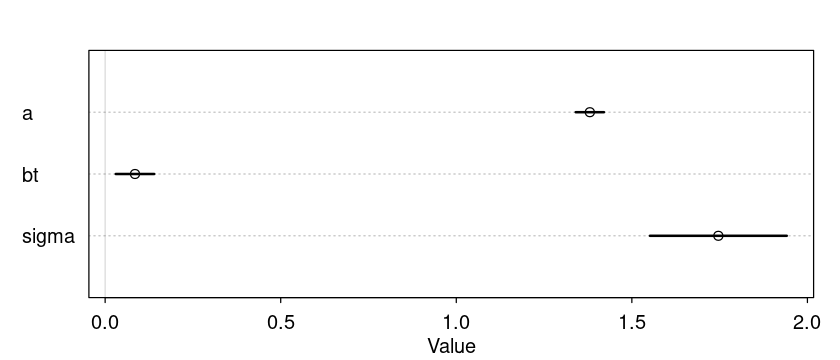

In [29]:
# R code 6.17
m6.8 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p <- a + bt*treatment,
        a ~ dlnorm(0, 0.2),
        bt ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d )
precis(m6.8)
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.8))

+ In this model, treatment has a positive impact - this is what we expect
+ The lesson is: Including post-treatment variables, can mask the causal influence of treatment.
+ 6.2.3 d-seperation

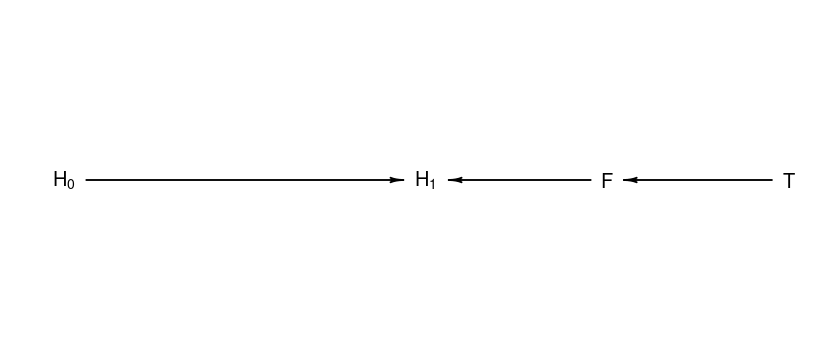

In [34]:
# R code 6.18
plant_dag <- dagitty( "dag {
    H_0 -> H_1
    F -> H_1
    T -> F}")
coordinates( plant_dag ) <- list( x=c(H_0=0,T=2,F=1.5,H_1=1) , y=c(H_0=0,T=0,F=0,H_1=0) )
drawdag( plant_dag )

In [19]:
help(rnorm)

Normal {stats},R Documentation
"x, q",vector of quantiles.
p,vector of probabilities.
n,"number of observations. If length(n) > 1, the length is taken to be the number required."
mean,vector of means.
sd,vector of standard deviations.
"log, log.p","logical; if TRUE, probabilities p are given as log(p)."
lower.tail,"logical; if TRUE (default), probabilities are P[X \le x] otherwise, P[X > x]."
